## Project of Machine Learning

Purpose : Find the best roommate with a data of Wellbeing and lifestyle

for this project, we use the dataset from Kaggle : https://www.kaggle.com/c/wellbeing-and-lifestyle/data

we must define whether we use classification or regression


Imports:

In [86]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

import math




Loading of the CSV data set

In [87]:
file_path = os.path.join(os.getcwd(), "Wellbeing_and_lifestyle_data.csv")

try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    df = None
    print("File not found")
print(df["GENDER"])
print("Column names:\n")
print(df.columns.tolist())

print("\nNumerical columns:\n")
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
print(num_cols.tolist())

print("\nCategorical columns:\n")
cat_cols = df.select_dtypes(include=['object', 'category']).columns
print(cat_cols.tolist())

file_path = os.path.join(os.getcwd(), "Wellbeing_and_lifestyle_data.csv")
try:
    for col in cat_cols:
        print(f"\nColumn: {col}")
        print(df[col].unique()[:15], "...")
        df = pd.read_csv(file_path)

except FileNotFoundError:
    print("File not found")
    
print(df["GENDER"])
print(df.describe())
print(df.head())



0        Female
1        Female
2        Female
3        Female
4        Female
          ...  
15966    Female
15967    Female
15968      Male
15969    Female
15970    Female
Name: GENDER, Length: 15971, dtype: object
Column names:

['Timestamp', 'FRUITS_VEGGIES', 'DAILY_STRESS', 'PLACES_VISITED', 'CORE_CIRCLE', 'SUPPORTING_OTHERS', 'SOCIAL_NETWORK', 'ACHIEVEMENT', 'DONATION', 'BMI_RANGE', 'TODO_COMPLETED', 'FLOW', 'DAILY_STEPS', 'LIVE_VISION', 'SLEEP_HOURS', 'LOST_VACATION', 'DAILY_SHOUTING', 'SUFFICIENT_INCOME', 'PERSONAL_AWARDS', 'TIME_FOR_PASSION', 'WEEKLY_MEDITATION', 'AGE', 'GENDER', 'WORK_LIFE_BALANCE_SCORE']

Numerical columns:

['FRUITS_VEGGIES', 'DAILY_STRESS', 'PLACES_VISITED', 'CORE_CIRCLE', 'SUPPORTING_OTHERS', 'SOCIAL_NETWORK', 'ACHIEVEMENT', 'DONATION', 'BMI_RANGE', 'TODO_COMPLETED', 'FLOW', 'DAILY_STEPS', 'LIVE_VISION', 'SLEEP_HOURS', 'LOST_VACATION', 'DAILY_SHOUTING', 'SUFFICIENT_INCOME', 'PERSONAL_AWARDS', 'TIME_FOR_PASSION', 'WEEKLY_MEDITATION', 'WORK_LIFE_BALANCE_S

In [88]:
# Ensure DAILY_STRESS is numeric
print(df["GENDER"])
df['DAILY_STRESS'] = pd.to_numeric(df['DAILY_STRESS'], errors='coerce')
before_rows = df.shape[0]
df = df.dropna(subset=['DAILY_STRESS'])
after_rows = df.shape[0]
print(f"Removed {before_rows - after_rows} row(s) with invalid DAILY_STRESS values.")

# Drop Timestamp column if it exists
for ts_col in ['Timestamp', 'TIMESTAMP']:
    if ts_col in df.columns:
        df = df.drop(columns=[ts_col])

print("\nAfter basic cleaning and encoding:")
df.info()
print("Shape after cleaning:", df.shape)
print(df["GENDER"])


0        Female
1        Female
2        Female
3        Female
4        Female
          ...  
15966    Female
15967    Female
15968      Male
15969    Female
15970    Female
Name: GENDER, Length: 15971, dtype: object
Removed 0 row(s) with invalid DAILY_STRESS values.

After basic cleaning and encoding:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15971 entries, 0 to 15970
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   FRUITS_VEGGIES           15971 non-null  int64  
 1   DAILY_STRESS             15971 non-null  int64  
 2   PLACES_VISITED           15971 non-null  int64  
 3   CORE_CIRCLE              15971 non-null  int64  
 4   SUPPORTING_OTHERS        15971 non-null  int64  
 5   SOCIAL_NETWORK           15971 non-null  int64  
 6   ACHIEVEMENT              15971 non-null  int64  
 7   DONATION                 15971 non-null  int64  
 8   BMI_RANGE                15971 non-null 

# Data exploration

## Types of Data
dtypes: float64(1), int64(19), object(4)

Object : Age, Gender, Timestamp, DAILY_STRESS

Float64 : Work_Life_Balance_Score

We must transform the Object into numerical values

For DAILY_STRESS => we had one data (1/1/0) who isn't INT on around 15K samples), result: we delete the row




In [89]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15971 entries, 0 to 15970
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   FRUITS_VEGGIES           15971 non-null  int64  
 1   DAILY_STRESS             15971 non-null  int64  
 2   PLACES_VISITED           15971 non-null  int64  
 3   CORE_CIRCLE              15971 non-null  int64  
 4   SUPPORTING_OTHERS        15971 non-null  int64  
 5   SOCIAL_NETWORK           15971 non-null  int64  
 6   ACHIEVEMENT              15971 non-null  int64  
 7   DONATION                 15971 non-null  int64  
 8   BMI_RANGE                15971 non-null  int64  
 9   TODO_COMPLETED           15971 non-null  int64  
 10  FLOW                     15971 non-null  int64  
 11  DAILY_STEPS              15971 non-null  int64  
 12  LIVE_VISION              15971 non-null  int64  
 13  SLEEP_HOURS              15971 non-null  int64  
 14  LOST_VACATION         

In [90]:
#GENDER
# onyl 2 values (Female and Male), so we translate this into 0 and 1
print(df["GENDER"])
df["GENDER"] = df["GENDER"].map({"Female": 0, "Male": 1})
print(df["GENDER"])
#Age
#We have 4 categories of Age :
#[less than 20, 21 to 35, 36 to 50, 51 or more]
# when it's possible, we take the half of age groupes
# for <20, we choose value : 16 and for 51 or more, we choose value : 70

# Convert AGE to numeric representation
age_mapping = {
    'Less than 20': 16,
    '21 to 35': 28,
    '36 to 50': 43,
    '51 or more': 70
}
df['AGE'] = df['AGE'].map(age_mapping)

if "Timestamp" in df.columns:
    df = df.drop(columns=["Timestamp"])
print(df.info())
print(df.shape)

0        Female
1        Female
2        Female
3        Female
4        Female
          ...  
15966    Female
15967    Female
15968      Male
15969    Female
15970    Female
Name: GENDER, Length: 15971, dtype: object
0        0
1        0
2        0
3        0
4        0
        ..
15966    0
15967    0
15968    1
15969    0
15970    0
Name: GENDER, Length: 15971, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15971 entries, 0 to 15970
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   FRUITS_VEGGIES           15971 non-null  int64  
 1   DAILY_STRESS             15971 non-null  int64  
 2   PLACES_VISITED           15971 non-null  int64  
 3   CORE_CIRCLE              15971 non-null  int64  
 4   SUPPORTING_OTHERS        15971 non-null  int64  
 5   SOCIAL_NETWORK           15971 non-null  int64  
 6   ACHIEVEMENT              15971 non-null  int64  
 7   DONATION          

Detailed Descriptive Statistics (including categorical)

In [91]:
print("Numerical feature statistics:")
display(df.describe())

# Check whether we have categorical columns
cat_cols = df.select_dtypes(include=["object", "category"]).columns
print("\nCategorical columns detected:", list(cat_cols))

if len(cat_cols) > 0:
    print("\nCategorical feature statistics:")
    display(df[cat_cols].describe())
else:
    print("\nNo categorical (object/category) columns in this dataset.")


Numerical feature statistics:


,FRUITS_VEGGIES,DAILY_STRESS,PLACES_VISITED,CORE_CIRCLE,SUPPORTING_OTHERS,SOCIAL_NETWORK,ACHIEVEMENT,DONATION,BMI_RANGE,TODO_COMPLETED,...,SLEEP_HOURS,LOST_VACATION,DAILY_SHOUTING,SUFFICIENT_INCOME,PERSONAL_AWARDS,TIME_FOR_PASSION,WEEKLY_MEDITATION,AGE,GENDER,WORK_LIFE_BALANCE_SCORE
count,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,...,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000
mean,2.922672,2.791685,5.233235,5.508296,5.616179,6.474047,4.000689,2.715171,1.410619,5.745977,...,7.042953,2.898441,2.931000,1.728946,5.711289,3.326279,6.233611,39.920168,0.382756,666.750510
std,1.442739,1.367801,3.311847,2.840287,3.241937,3.086643,2.755912,1.851556,0.491962,2.624179,...,1.199053,3.691867,2.676341,0.444518,3.089540,2.729128,3.016479,17.729522,0.486075,45.021103
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,16.000000,0.000000,480.000000
25%,2.000000,2.000000,2.000000,3.000000,3.000000,4.000000,2.000000,1.000000,1.000000,4.000000,...,6.000000,0.000000,1.000000,1.000000,3.000000,1.000000,4.000000,28.000000,0.000000,636.000000
50%,3.000000,3.000000,5.000000,5.000000,5.000000,6.000000,3.000000,3.000000,1.000000,6.000000,...,7.000000,0.000000,2.000000,2.000000,5.000000,3.000000,7.000000,43.000000,0.000000,667.700000
75%,4.000000,4.000000,8.000000,8.000000,9.500000,10.000000,6.000000,5.000000,2.000000,8.000000,...,8.000000,5.000000,4.000000,2.000000,9.000000,5.000000,10.000000,43.000000,1.000000,698.500000
max,5.000000,5.000000,10.000000,10.000000,10.000000,10.000000,10.000000,5.000000,2.000000,10.000000,...,10.000000,10.000000,10.000000,2.000000,10.000000,10.000000,10.000000,70.000000,1.000000,820.200000



Categorical columns detected: []

No categorical (object/category) columns in this dataset.


Missing Values Map (visual)

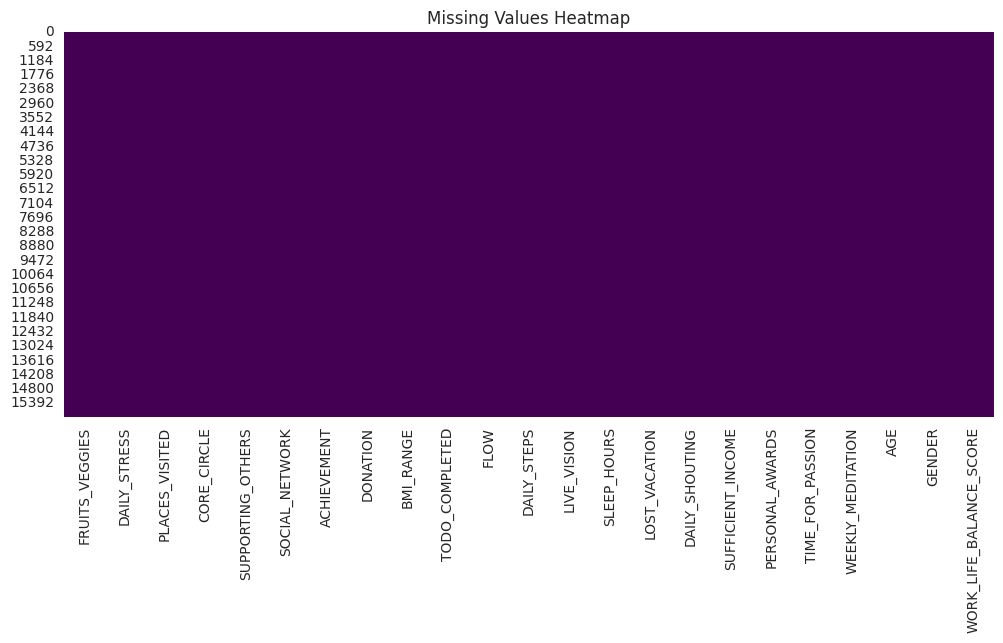

In [92]:
# MISSING VALUE VISUALIZATION

plt.figure(figsize=(12, 5))
sns.heatmap(df.isna(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()


Histograms for All Numerical Features

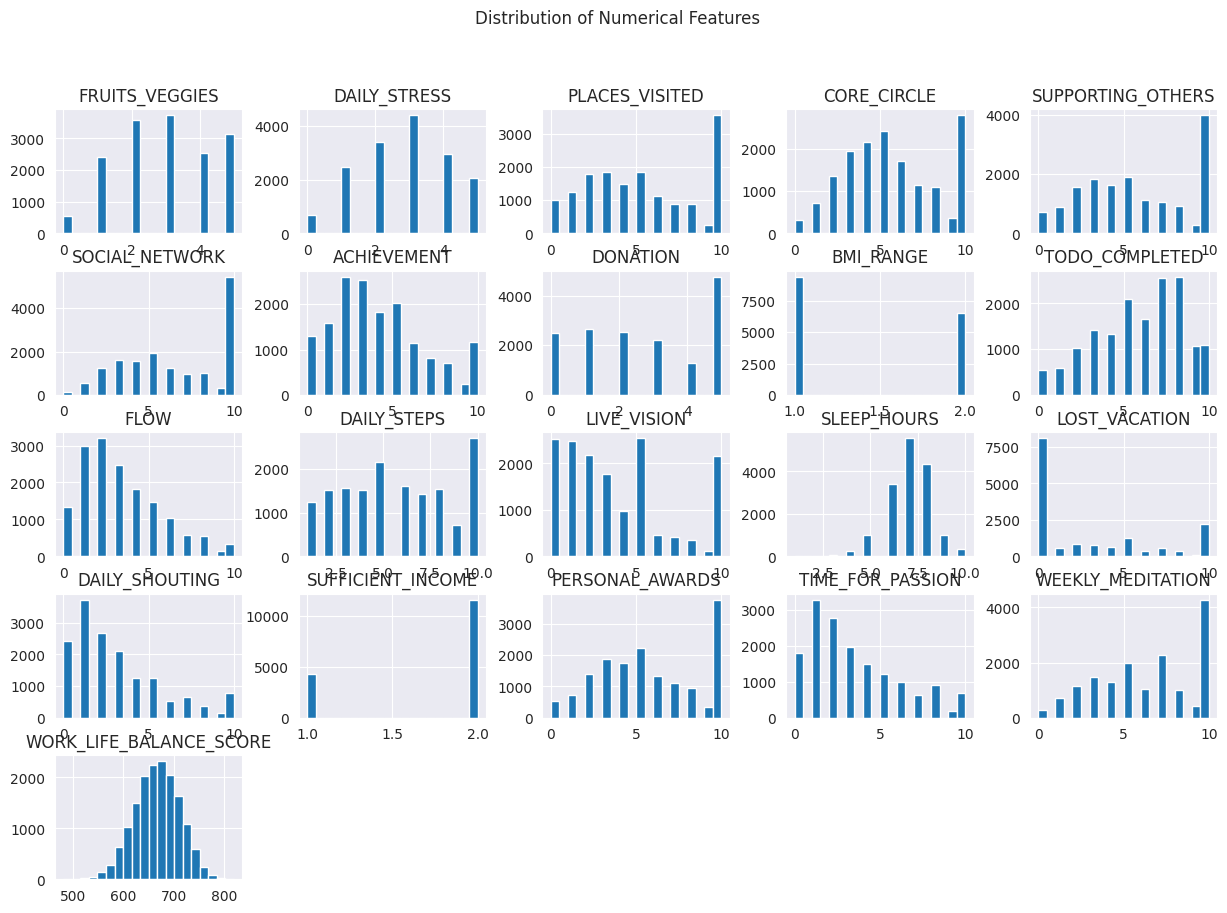

In [93]:
# HISTOGRAMS OF ALL NUMERICAL FEATURES

df[num_cols].hist(figsize=(15, 10), bins=20)
plt.suptitle("Distribution of Numerical Features")
plt.show()


Boxplots to Detect Outliers

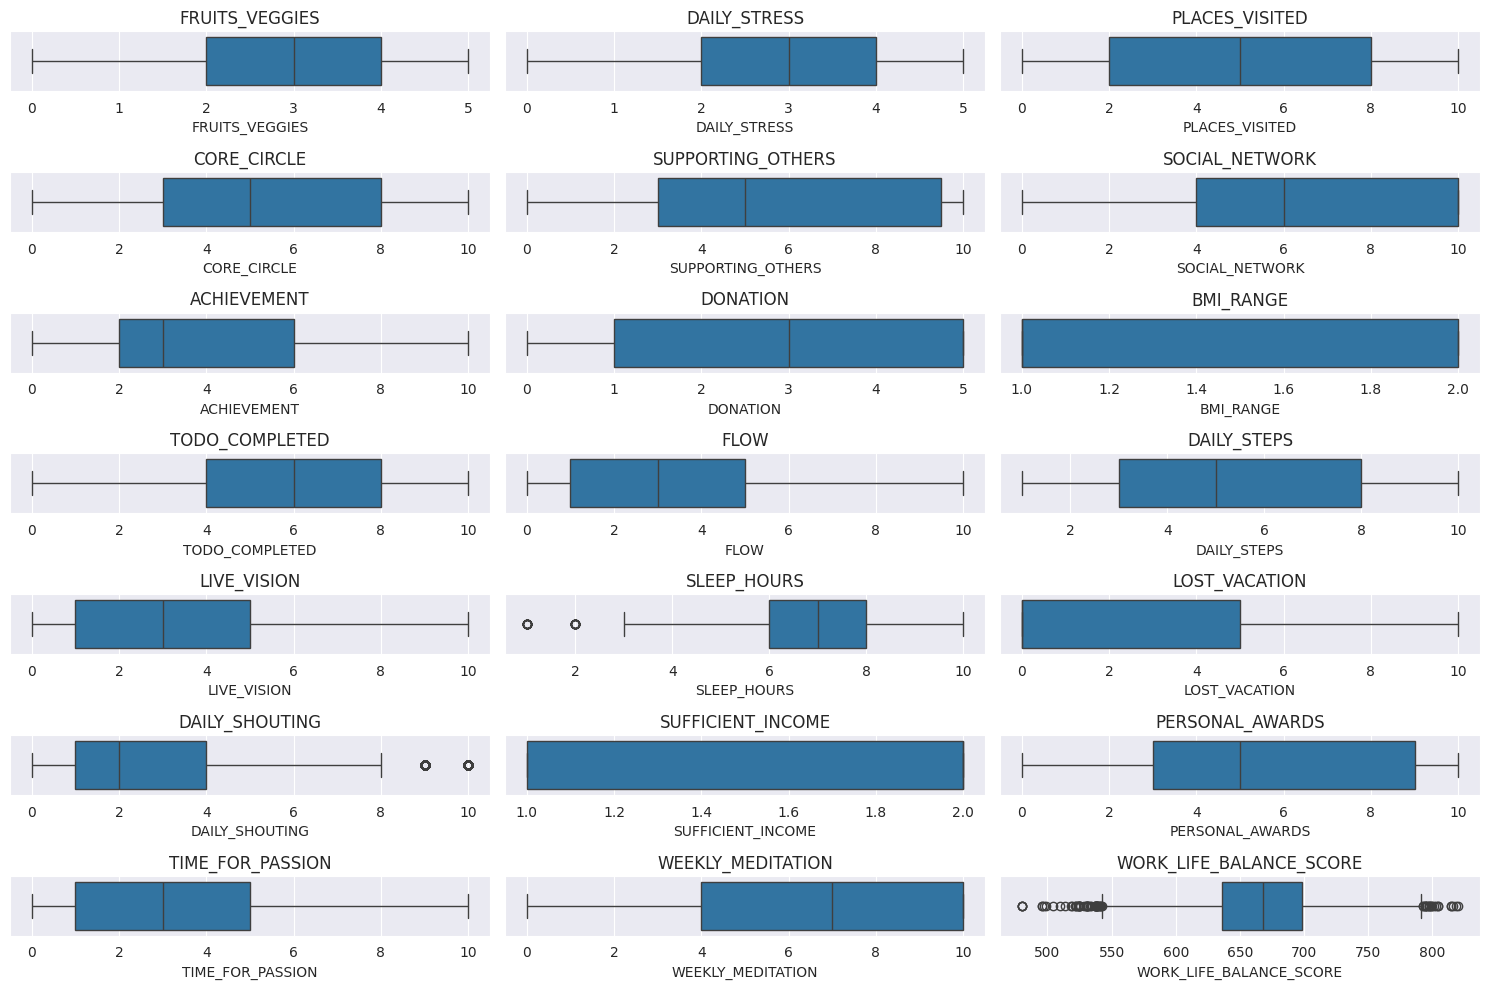

In [94]:
# BOXPLOTS FOR OUTLIER DETECTION

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols):
    plt.subplot(math.ceil(len(num_cols)/3), 3, i+1)
    sns.boxplot(x=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()


Correlation Matrix Heatmap (Numerical Only)

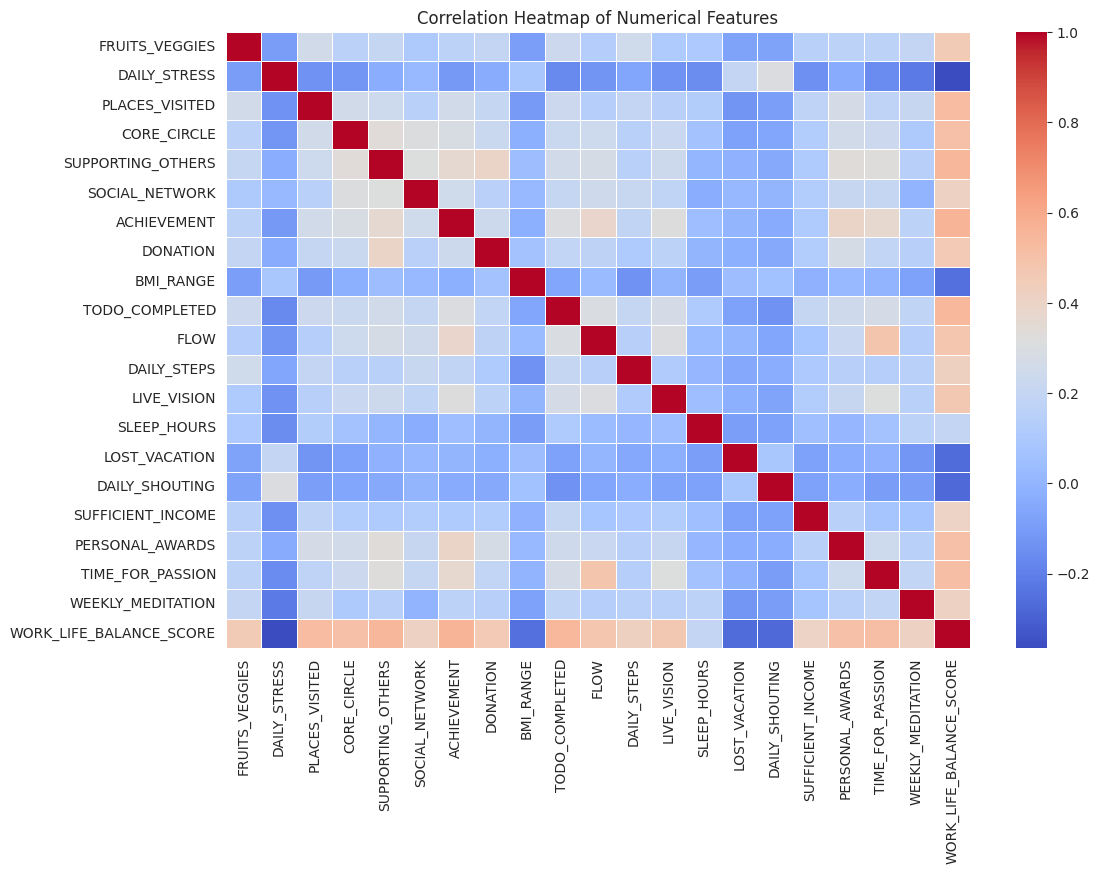

In [95]:
# CORRELATION HEATMAP

corr = df[num_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


Unique Values of Categorical Features

In [96]:
if len(cat_cols) == 0:
    print("No categorical columns left after encoding.")
else:
    for col in cat_cols:
        print(f"\nColumn: {col}")
        print(df[col].unique()[:15], "...")


No categorical columns left after encoding.


Basic Preprocessing Checks (without altering existing work)

In [97]:
# PREPROCESSING CHECKLIST

print("Missing values left:")
print(df.isna().sum())

print("\nDuplicate rows:", df.duplicated().sum())

print("\nData types:")
print(df.dtypes)


Missing values left:
FRUITS_VEGGIES             0
DAILY_STRESS               0
PLACES_VISITED             0
CORE_CIRCLE                0
SUPPORTING_OTHERS          0
SOCIAL_NETWORK             0
ACHIEVEMENT                0
DONATION                   0
BMI_RANGE                  0
TODO_COMPLETED             0
FLOW                       0
DAILY_STEPS                0
LIVE_VISION                0
SLEEP_HOURS                0
LOST_VACATION              0
DAILY_SHOUTING             0
SUFFICIENT_INCOME          0
PERSONAL_AWARDS            0
TIME_FOR_PASSION           0
WEEKLY_MEDITATION          0
AGE                        0
GENDER                     0
WORK_LIFE_BALANCE_SCORE    0
dtype: int64

Duplicate rows: 683

Data types:
FRUITS_VEGGIES               int64
DAILY_STRESS                 int64
PLACES_VISITED               int64
CORE_CIRCLE                  int64
SUPPORTING_OTHERS            int64
SOCIAL_NETWORK               int64
ACHIEVEMENT                  int64
DONATION            

## PCA of the data



In [98]:
from sklearn.decomposition import PCA
X_train, X_test = train_test_split(df, test_size=0.2, random_state=0)

scaler = MinMaxScaler()
normalized_df = scaler.fit_transform(X_train)
plt.figure(figsize=(8,6))


NameError: name 'train_test_split' is not defined

In [ ]:
#Covariance Matrix
cov = np.cov(normalized_df)

print(cov)
print(cov.shape)

if cov.shape < (10,10):
    sns.heatmap(cov, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Covariance Heatmap")


[[ 1.22856600e-01  1.63792172e-02  8.57282019e-03 ...  6.48583938e-02
  -6.84682532e-05  3.74323141e-02]
 [ 1.63792172e-02  1.21017879e-01  4.29050009e-02 ... -3.60177107e-02
   3.81518742e-02 -2.21918960e-02]
 [ 8.57282019e-03  4.29050009e-02  1.20038290e-01 ...  1.29819311e-02
  -2.99421207e-02  9.04356159e-03]
 ...
 [ 6.48583938e-02 -3.60177107e-02  1.29819311e-02 ...  1.29501046e-01
  -4.33487557e-02  5.65727187e-02]
 [-6.84682532e-05  3.81518742e-02 -2.99421207e-02 ... -4.33487557e-02
   1.16272304e-01 -3.38961880e-02]
 [ 3.74323141e-02 -2.21918960e-02  9.04356159e-03 ...  5.65727187e-02
  -3.38961880e-02  1.00796907e-01]]
(12776, 12776)


In [ ]:
#Correlation Matrix from Numpy

corrNP= np.corrcoef(normalized_df)
print(corrNP.shape)
if corrNP.shape < (10,10):
    sns.heatmap(corrNP, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap")

(12776, 12776)


(23, 23)


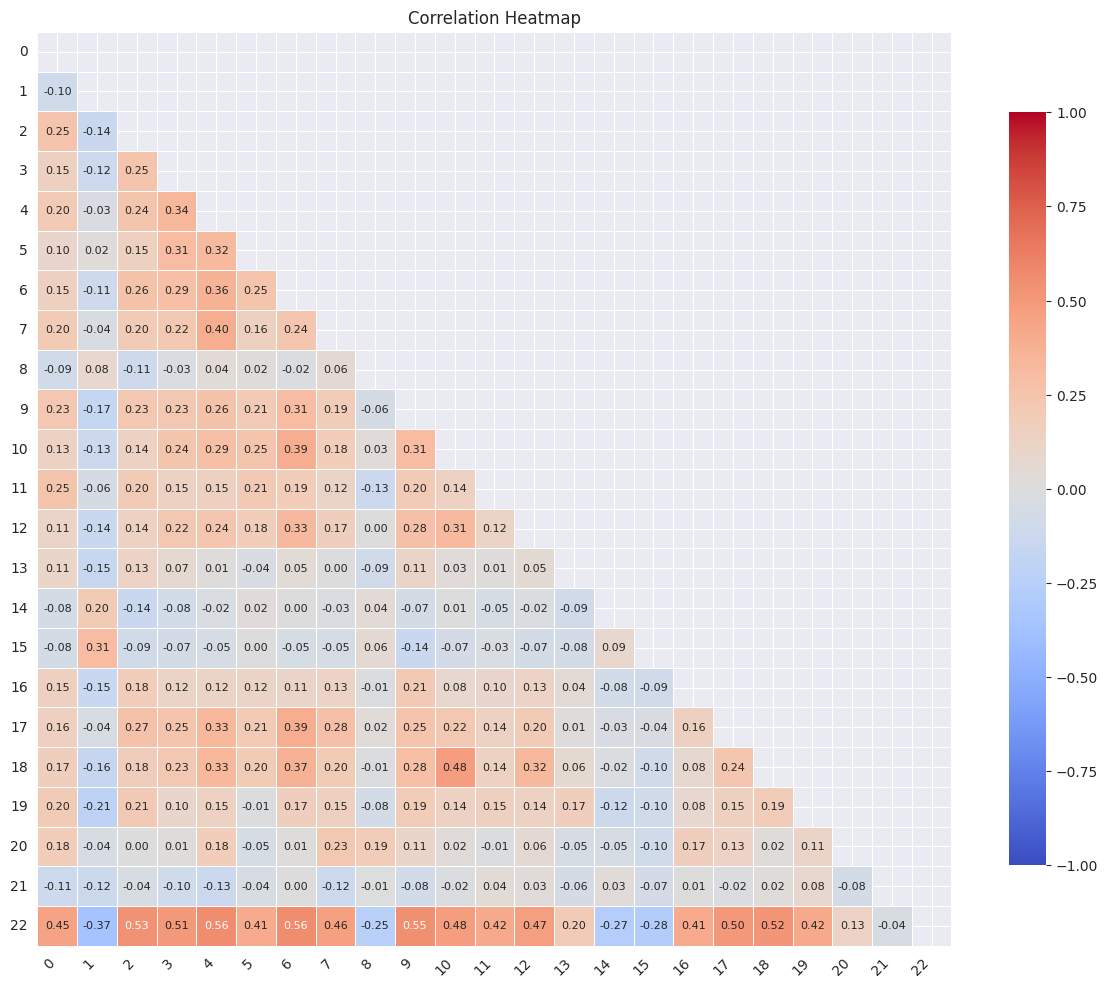

In [ ]:
#Correlation Matrix from Pandas

corrPD = pd.DataFrame(normalized_df).corr()
print(corrPD.shape)
if corrPD.shape <= (23, 23):
    mask = np.triu(np.ones_like(corrPD, dtype=bool))
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(
        corrPD,
        mask=mask,
        annot=True,
        annot_kws={"size": 8},
        cmap="coolwarm",
        vmin=-1,
        vmax=1,
        fmt=".2f",
        linewidths=0.5,
        linecolor="white",
        square=True,
        cbar_kws={"shrink": 0.8}
    )
    plt.title("Correlation Heatmap")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()


In [ ]:


X_test = scaler.transform(X_test)
pca = PCA(n_components=8)
X_train = pca.fit_transform(normalized_df)
X_test = pca.transform(X_test)

explained_variance = pca.explained_variance_ratio_

print(explained_variance)
print(sum(explained_variance))


[0.17387086 0.11178575 0.10129109 0.07776802 0.06131803 0.05203576
 0.04451781 0.0417142 ]
0.664301521322969


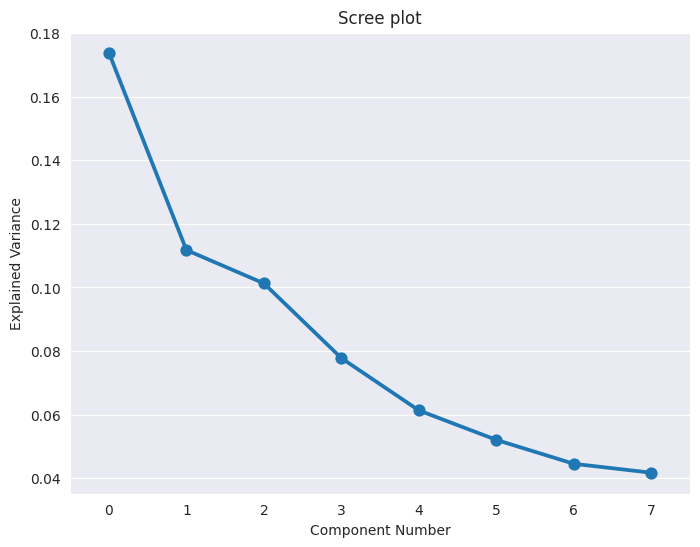

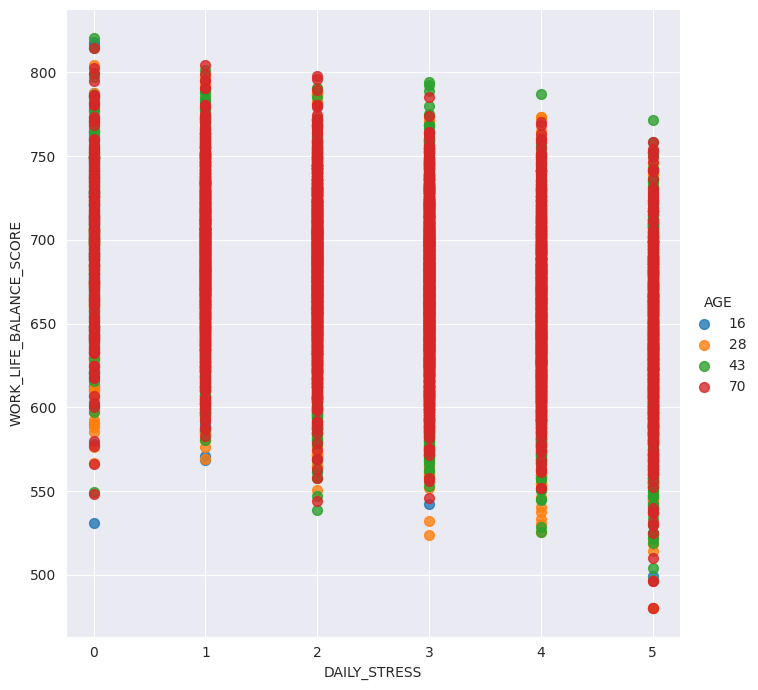

Text(0.5, 1.0, 'Variable factor map')

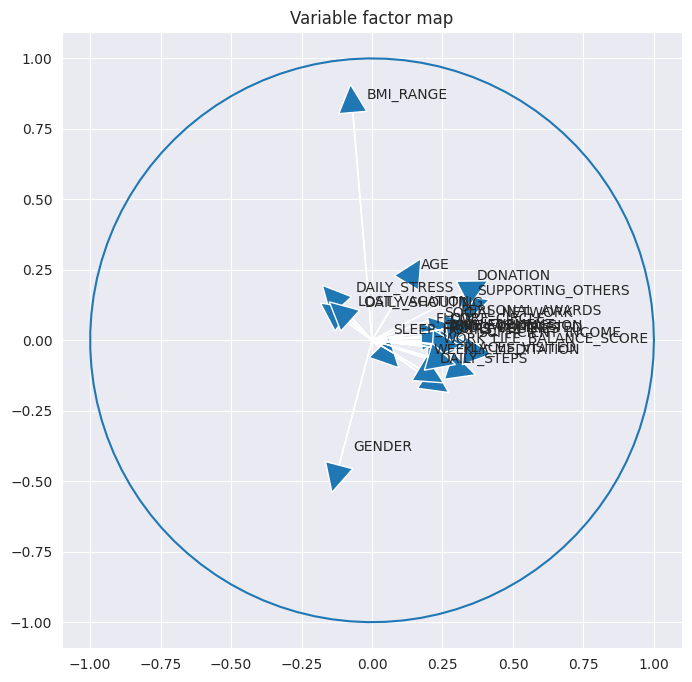

In [ ]:
ind = np.arange(0, pca.n_components_)
(fig, ax) = plt.subplots(figsize=(8, 6))
sns.pointplot(x=ind, y=pca.explained_variance_ratio_)
ax.set_title('Scree plot')
ax.set_xticks(ind)
ax.set_xticklabels(ind)
ax.set_xlabel('Component Number')
ax.set_ylabel('Explained Variance')
plt.show()

# Show the points in terms of the first two PCs
g = sns.lmplot(
    x='DAILY_STRESS',
    y='WORK_LIFE_BALANCE_SCORE',
    hue='AGE',
    data=df,
    fit_reg=False,              # or: line_kws={'linewidth': 0} if needed
    height=7,                   # replaces size=7
    scatter_kws={'s': 50}       # control point size instead of scatter=True
)

plt.show()

# Plot a variable factor map for the first two dimensions.
(fig, ax) = plt.subplots(figsize=(8, 8))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.1,
             head_length=0.1)

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             df.columns.values[i])


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
ax.set_title('Variable factor map')


(8, 23)


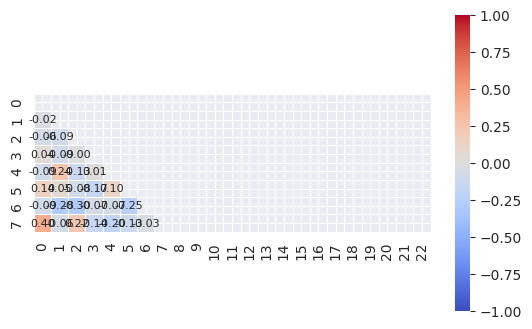

In [ ]:

mask = np.triu(np.ones_like(pca.components_, dtype=bool))  # upper triangle mask

sns.heatmap(
    pca.components_,
    mask=mask,
    annot=True,
    annot_kws={"size": 8},
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    fmt=".2f",
    linewidths=0.5,
    linecolor="white",
    square=True,
    cbar_kws={"shrink": 0.8}
)

print(pca.components_.shape)